In [1]:
# Import the required packages #################################################
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from prefig import Prefig
from calc_kcor import calc_kcor

cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

data_file = 'full_sample_w_urls_and_sfrs.fits'
data_dir = '../../fits/'
save_dir = '../../fits/'
fig_dir = '../../figures/samples/'

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [4]:
full = Table.read(data_dir + data_file)

remove_low_z = full['REDSHIFT_1'] >= 0.03
full = full[remove_low_z]

In [5]:
def get_sample_limits(z,table):
    
    z_max=[z] # Define the maximum redshift.
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0]) # Define the
    # maximum distance from the max redshift.
    m_limit=17 # Maximum apparent magnitude to be used to cut the sample.
    k_val = calc_kcor('r',z,'g - r',0.8)
    M_limit=m_limit - 5*(math.log10(D_max) - 1) - k_val

    return z_max,M_limit

In [6]:
def output_vls_sizes(table,N_steps=1000,z_min=0.03):
    
    z_vals = np.linspace(np.min(table['REDSHIFT_1']),np.max(table['REDSHIFT_1']),N_steps)
    # Replace the value closest to 0.085 with the exact value 
    # (as it is a 'special' value where we have environment data)
    z_vals[find_nearest(z_vals,0.085)] = 0.085
    sizes=np.zeros((N_steps,2))

    for z in enumerate(z_vals):
        z_max,M_limit = get_sample_limits(z=z[1],table=table)
        select = ((table['PETROMAG_MR'] <= M_limit) & (table['REDSHIFT_1'] <= z_max) 
                  & (table['REDSHIFT_1'] >= z_min))# & (table['mag'] <= 17))
        sizes[z[0],:] = np.array([z[1],np.sum(select)])
  
    sizes = Table(sizes,names=('redshift','N_gal'))
        
    return sizes

In [7]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def plot_line(max_sample,style,label):
    lines=np.array([[0,max_sample[0],max_sample[0]],[max_sample[1],max_sample[1],0]])
    plt.plot(lines[0],lines[1],style,label=label,linewidth=2)
    return None

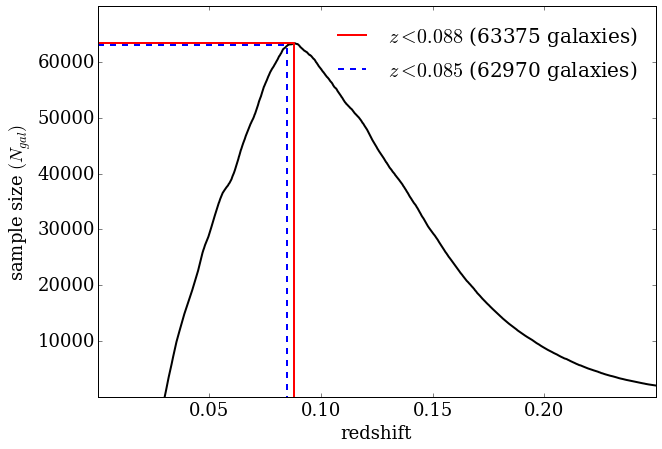

In [25]:
plt.figure(figsize=(10,7))
styles=["b--","g:"]

sizes=output_vls_sizes(table=full,N_steps=1000)
plt.plot(sizes['redshift'],sizes['N_gal'],"k-",linewidth=2)

max_sample=sizes[np.argmax(sizes['N_gal'])]
plot_line(max_sample,"r-",label="$z<{0:.3f}$".format(max_sample[0]) 
          + " ({0:.0f} galaxies)".format(max_sample[1]))

for z in enumerate([0.085]):
    max_sample=sizes[find_nearest(array=sizes['redshift'],value=z[1])]
    plot_line(max_sample,styles[z[0]],label="$z<{0:.3f}$".format(max_sample[0]) 
              + " ({0:.0f} galaxies)".format(max_sample[1]))
    
plt.xlabel('redshift')
plt.ylabel('sample size $(N_{gal})$')
plt.xticks(np.arange(0.05,0.25,0.05))
plt.legend(fontsize=20,frameon=False)
        
plt.savefig(fig_dir + 'sample_sizes.pdf')

In [26]:
def get_volume_limited_sample(z,full_data,maximise=False,z_min=0.03,plot=None):
    
    if maximise == True:
        sizes = output_vls_sizes(table=full_data)
        z = sizes[np.argmax(sizes['N_gal'])]['redshift']
    
    z_max,M_limit = get_sample_limits(z,full)
    
    select = ((full_data['REDSHIFT_1'] >= z_min) 
               & (full_data['REDSHIFT_1'] <= z_max) 
               & (full_data['PETROMAG_MR'] <= M_limit)
               & (full_data['PETROMAG_R'] <= 17.0)) # Remove 'deep' images.
    
    if plot is not None:
        
        label_full = 'full sample ($N_{gal}=' + '{}$)'.format(len(full_data))
        label_vl = 'luminosity limited sample ($N_{gal}=' + '{}$)'.format(np.sum(select))
        
        plt.figure(figsize=(10,7))
        full_plot = full_data[full_data['PETROMAG_R'] <= 17.0]
        sort = np.arange(0,len(full_plot))
        np.random.shuffle(sort)
        x_scatter = full_plot['REDSHIFT_1'][sort][0:plot]
        y_scatter = full_plot['PETROMAG_MR'][sort][0:plot]
        
        plt.scatter(x_scatter,y_scatter,color='b',marker='.',s=40,alpha=0.75,label=label_full)
        plt.hlines(M_limit,z_min,z_max,'k',linewidth=2,label=label_vl)
        plt.vlines(z_min,M_limit,-25,'k',linewidth=2)
        plt.vlines(z_max,M_limit,-25,'k',linewidth=2)
        
        plt.xlabel('redshift')
        plt.ylabel('$M_r$')
        plt.xlim([0,0.25])
        plt.ylim([-17.5,-24.5])
        plt.legend(loc=4,prop={'size':15})
        
        plt.savefig(fig_dir + 'volume_limited_sample.pdf',dpi=100)

    print('M_r limit = {}, {} galaxies in sample'.format(M_limit,np.sum(select)))
    
    return select

In [21]:
# Do we want to remove stripe82????

#s82_select = np.array(['stripe82' in s for s in full['sample']]).T
#s82 = full[s82_select]
#normal = full[s82_select == False]

plt.scatter(s82['REDSHIFT_1'],s82['PETROMAG_MR'],alpha=0.1,color='red')
plt.scatter(normal['REDSHIFT_1'],normal['PETROMAG_MR'],alpha=0.1,color='blue')
plt.xlim(0,0.3)
plt.ylim(-16,-25)
plt.xlabel('redshift')
plt.ylabel('$M_r$')
# Can see here that stripe 82 goes below the m_r=17 selection limit. 

NameError: name 's82' is not defined

M_r limit = -21.006979342196836, 62220 galaxies in sample


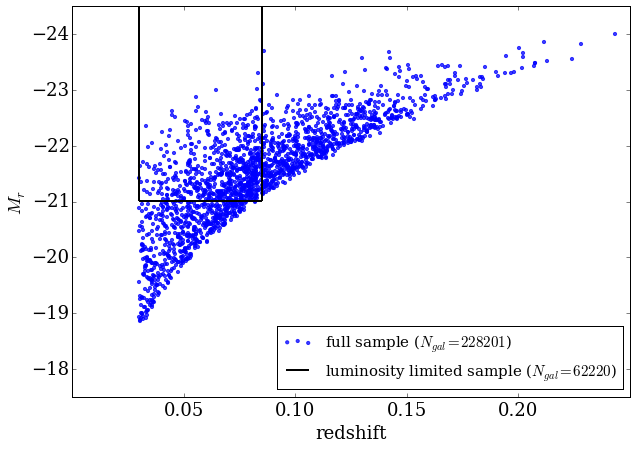

In [27]:
select = get_volume_limited_sample(z=0.085,full_data=full,z_min=0.03,plot=2000)
vl = full[select]

In [29]:
full['in_volume_limit'] = select # Add column for galaxies in the volume limit.

In [30]:
full.write(save_dir + 'full_sample.fits',overwrite=True)

(10.3, 10.7)

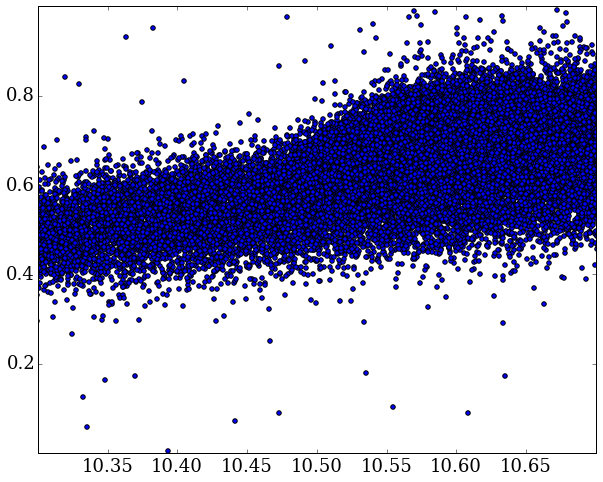

In [114]:
vl_m = vl[np.isfinite(vl['LOGMSTAR_BALDRY06'])]
plt.scatter(vl_m['LOGMSTAR_BALDRY06'],vl['PETROMAG_MG']-vl['PETROMAG_MR'])

#vl_m['PETROMAG_MR']
plt.ylim(0,1)
plt.xlim(10.3,10.7)